* Author: Hardik Rajput

* Date: 7/02/2022

* Project Name: Sales Prediction using Time Series : ARIMA

# Sales Prediction using Time Series : ARIMA(AutoRegressive Integrated Moving Average)¶

In this project I will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.

I have to predict total sales for every product and store in the next month.

# Data Description

I have daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. I have to create a robust model that can handle such situations.


## File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.


## Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

* Install **pmdarima** statistical library: Pmdarima (pyramid-arima) is a statistical library designed to fill the void in Python's time series analysis capabilities. pmdarima is essentially a Python & Cython wrapper of several different statistical and machine learning libraries (statsmodels and scikit-learn), and operates by generalizing all ARIMA models into a single class (unlike statsmodels).

* Import **statsmodels**: This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components. It provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. 

* Import libarary such as pandas, numpy matplotlib

In [9]:
!pip install pmdarima

In [10]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima

In [11]:
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')

df_train.shape, df_test.shape

((2935849, 6), (214200, 3))

In [12]:
df_train.dtypes, df_test.columns

(date               object
 date_block_num      int64
 shop_id             int64
 item_id             int64
 item_price        float64
 item_cnt_day      float64
 dtype: object,
 Index(['ID', 'shop_id', 'item_id'], dtype='object'))

In [ ]:
#To datetime datatype
df_train['date'] = df_train['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [ ]:
df_train['month'] = df_train['date'].dt.to_period('M')
df_train['month'] = df_train['month'].astype(str)
df_train['month'] = pd.to_datetime(df_train['month'])
df_train.dtypes

In [16]:
dff_train = df_train.groupby(['month']).agg({'item_cnt_day':'sum'})
dff_train['month'] = dff_train.index
dff_train.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
print(dff_train.shape, dff_train.columns)

(34, 2) Index(['item_cnt_month', 'month'], dtype='object')


In [17]:
#dff_train.head(10)
len(dff_train.drop(['month'], axis = 1))

34

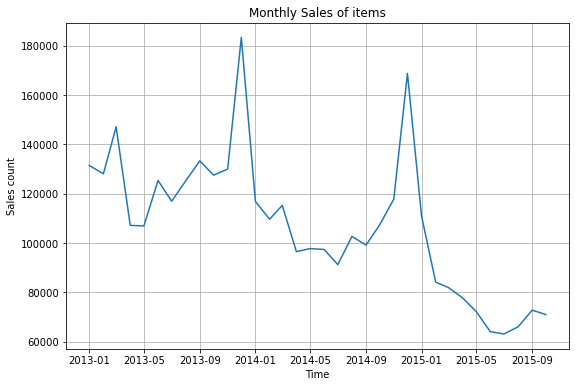

In [18]:
plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(dff_train['item_cnt_month'])
plt.title('Monthly Sales of items')
plt.xlabel('Time')
plt.ylabel('Sales count')
plt.show()

Autocorrelation = 0.6636


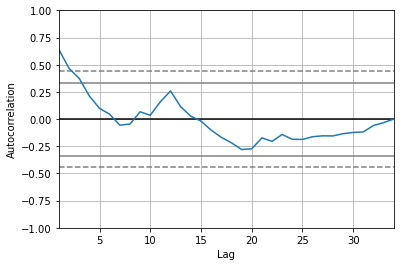

In [19]:
pd.plotting.autocorrelation_plot(dff_train['item_cnt_month'])
print('Autocorrelation =', round(dff_train['item_cnt_month'].autocorr(), 4))

H:\Software\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


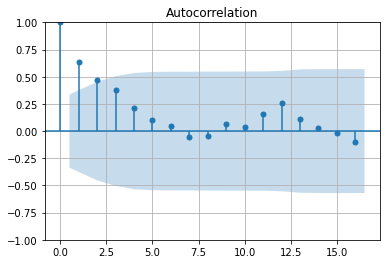

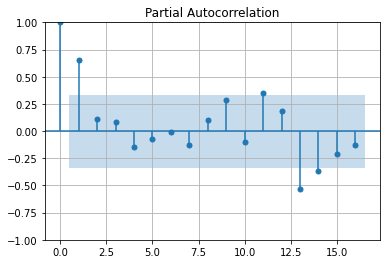

In [20]:
plot_acf(dff_train['item_cnt_month'])
plt.grid()
plot_pacf(dff_train['item_cnt_month'])
plt.grid()
plt.show()

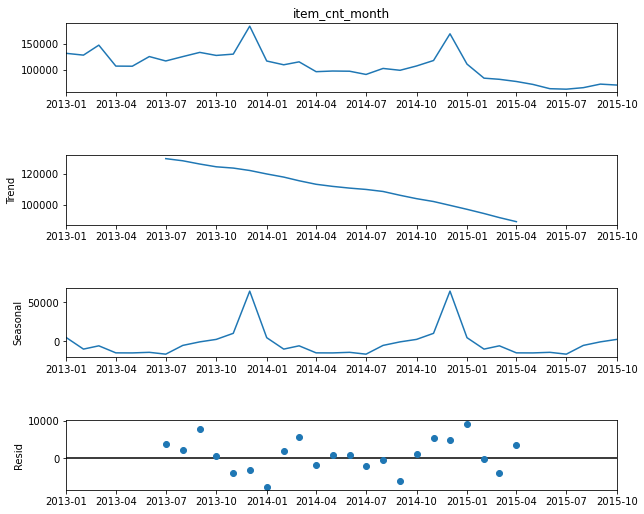

In [21]:
seasonal_decompose(dff_train['item_cnt_month'], model = 'additive').plot().set_size_inches(10, 8)

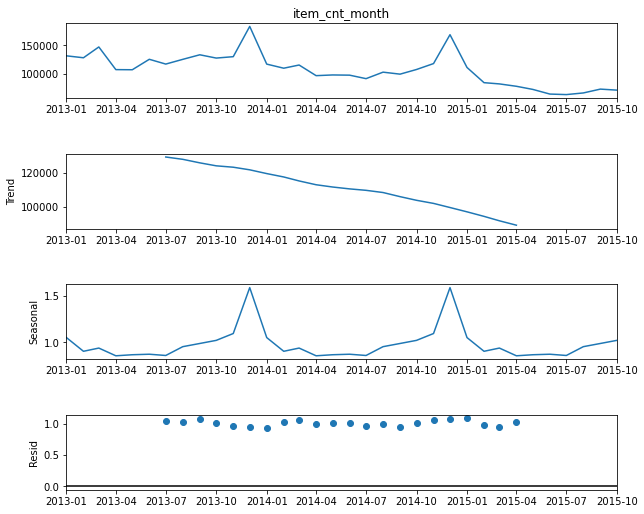

In [22]:
seasonal_decompose(dff_train['item_cnt_month'], model = 'multiplicative').plot().set_size_inches(10, 8)

In [23]:
#Stationarity test: Two tests for checking the stationarity of a time series are used, namely the ADF test and the KPSS test.
def adf_test(dataseries):
    adf = adfuller(dataseries)
    output = pd.Series(adf[0:3], index = ['ADF Statistic', 'p-value', 'Lags'])
    for key, value in adf[4].items():
        output["Critical Value (%s)" %key] = value
    
    return print(output)

In [24]:
adf_test(dff_train['item_cnt_month'])

ADF Statistic          -2.395704
p-value                 0.142953
Lags                    0.000000
Critical Value (1%)    -3.646135
Critical Value (5%)    -2.954127
Critical Value (10%)   -2.615968
dtype: float64


In [25]:
#Grid search for parameters
def order_parameters(training_data):
    
    search_params = auto_arima(training_data, start_p = 0, start_q = 0, m = 12, seasonal = True, test = "adf", d = None, trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, 
                    stepwise = True)
 
    print("AIC = ", round(search_params.aic(), 2))
                  
    return search_params

In [26]:
model = order_parameters(dff_train['item_cnt_month'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=448.765, Time=0.24 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=451.736, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=449.440, Time=0.07 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=438.095, Time=0.10 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=439.392, Time=0.16 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=438.173, Time=0.10 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=440.703, Time=0.28 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=448.622, Time=0.04 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=451.418, Time=0.11 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=449.122, Time=0.06 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=439.24

In [27]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -216.048
Date:                            Sat, 27 Aug 2022   AIC                            438.095
Time:                                    16:40:45   BIC                            441.082
Sample:                                01-01-2013   HQIC                           438.678
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9856      0.298     -3.311      0.001      -1.569      -0.402
ma.S.L12      -0.0853      0.168   

In [28]:
prediction, confint = model.predict(n_periods = 6, return_conf_int = True) #95% CI default
df_confint = pd.DataFrame(confint)
print(confint.round(2))
print(prediction.round(2))

[[ 49454.95 106326.13]
 [ 84822.5  166627.74]
 [ 14725.65 116582.4 ]
 [-22076.08  97438.41]
 [-34511.53 101209.37]
 [-50584.33 100364.26]]
2015-11-01     77890.54
2015-12-01    125725.12
2016-01-01     65654.02
2016-02-01     37681.17
2016-03-01     33348.92
2016-04-01     24889.97
Freq: MS, dtype: float64


In [29]:
period_index = pd.period_range(start = dff_train.index[-1], periods = 6, freq='M')

df_predict = pd.DataFrame({'Predicted item_cnt_month': prediction.round(2)}, index = period_index)
#df_predict['month'] = df_predict.index
print(df_predict)

         Predicted item_cnt_month
2015-10                       NaN
2015-11                       NaN
2015-12                       NaN
2016-01                       NaN
2016-02                       NaN
2016-03                       NaN


In [31]:
#Sales of November 2015

df_predict.head(2)

,Predicted item_cnt_month
2015-10,NaN
2015-11,NaN


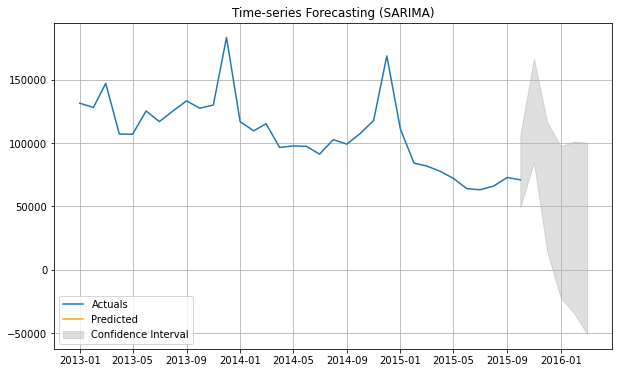

In [32]:
plt.figure(figsize = (10, 6))
plt.plot(dff_train['item_cnt_month'], label = 'Actuals')
plt.plot(df_predict.to_timestamp(), color = 'orange', label = 'Predicted')
plt.fill_between(period_index.to_timestamp(), df_confint[0], df_confint[1], color = 'grey', alpha = 0.25, label = 'Confidence Interval')
plt.legend(loc = 'lower left')
plt.title('Time-series Forecasting (SARIMA)')
plt.grid()
plt.show()

In [33]:
train_df_tuple = df_train.groupby(['shop_id', 'item_id'])['date', 'item_cnt_day'].agg({'item_cnt_day':'sum'})
train_df_tuple = train_df_tuple.reset_index()
print(train_df_tuple)

C:\Users\hrajput1\AppData\Local\Temp\ipykernel_2220\3415957417.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_df_tuple = df_train.groupby(['shop_id', 'item_id'])['date', 'item_cnt_day'].agg({'item_cnt_day':'sum'})


        shop_id  item_id  item_cnt_day
0             0       30          31.0
1             0       31          11.0
2             0       32          16.0
3             0       33           6.0
4             0       35          15.0
...         ...      ...           ...
424119       59    22154           1.0
424120       59    22155           1.0
424121       59    22162          16.0
424122       59    22164           6.0
424123       59    22167           4.0

[424124 rows x 3 columns]


In [34]:
df_test['item_cnt_month'] = (prediction[0].round(2)*len(df_test)/len(train_df_tuple))/len(df_test)
#df_test['item_cnt_month'] = prediction[0]*len(df_test)/len(train_df_tuple)
submission  = df_test.drop(['shop_id', 'item_id'], axis = 1)
print(submission)

            ID  item_cnt_month
0            0         0.18365
1            1         0.18365
2            2         0.18365
3            3         0.18365
4            4         0.18365
...        ...             ...
214195  214195         0.18365
214196  214196         0.18365
214197  214197         0.18365
214198  214198         0.18365
214199  214199         0.18365

[214200 rows x 2 columns]


In [35]:
submission.to_csv('submission.csv', index = False)